In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import statsmodels.api as sm
from scipy.stats import ttest_ind
import json
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind, ttest_1samp
from typing import List,Dict,Tuple,Union
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison




In [156]:
overall_df = pd.read_excel('20_part_May_10_Sat/Satisfaction_ratings/final_Sat_Overall.xlsx')
overall_df_first_half = pd.read_excel('20_part_May_10_Sat/Satisfaction_ratings/first_half/final_Sat_Overall_First_Half.xlsx')
overall_df_second_half = pd.read_excel('20_part_May_10_Sat/Satisfaction_ratings/second_half/final_Sat_Overall_Second_Half.xlsx')
trials_df = pd.read_excel("stimuli_29Apr24_5_trials.xlsx")


#Load suspense data

susp_filtered_df_1st = pd.read_excel('susp_filtered_df_1st.xlsx')
suspense_sum = pd.read_excel('suspense_sum.xlsx')


In [157]:

grouped_df = overall_df.groupby(by=['game','participant'], as_index=False)

full_dataframe = pd.DataFrame()

for meta, dataframe in grouped_df: 
    dataframe.sort_values(by='pair_number', ascending=True, inplace = True)
    dataframe['count'] = dataframe['card_1'].cumsum()
    full_dataframe = pd.concat([full_dataframe, dataframe])
overall_df = full_dataframe.copy()



### Exclude bad particants with catch trial results

First, we have to re-integrate the pseudo-randomisation by game in the overall_df as the data is extracted without it

- Game 0: 1-1-1-2-2
- Game 1: 1-1-2-2-1
- Game 3: 2-2-2-1-1

- Game 7: 1-1-2-2-1
- Game 9: 2-2-2-1-1
- Game 11: 2-1-1-2-1

- Game 12: 1-1-1-2-2
- Game 14: 1-2-21-2
- Game 15: 2-2-2-1-1
- Game 16: 2-2-1-1-2

- Game 19: 1-1-2-2-1
- Game 20: 1-2-2-1-2
- Game 22: 2-2-1-1-2

- Game 25: 1-1-2-2-1
- Game 28: 2-2-1-1-2
- Game 29: 2-1-1-2-1

- Game 32: 1-2-2-1-2
- Game 33: 2-2-2-1-1
- Game 34: 2-2-1-1-2

In [158]:
#sort overall dataframe by game
overall_df.sort_values(by="game",ascending=True)


,rt,catch_response,sat_rating,trial,game,pair_number,card_1,card_2,count,expected_outcome,suspense_level,participant
20,3084,1,NaN,4,0,1,-6,1,-6,winning,low suspense,Participant1
294,1381,0,1.076930,4,0,5,-4,1,-17,winning,low suspense,Participant4
293,5589,1,NaN,4,0,4,-3,1,-13,winning,low suspense,Participant4
292,3689,0,NaN,4,0,3,-5,-4,-10,winning,low suspense,Participant4
291,2603,1,NaN,4,0,2,1,-4,-5,winning,low suspense,Participant4
...,...,...,...,...,...,...,...,...,...,...,...,...
1211,1787,0,NaN,8,34,2,-3,2,-1,losing,high suspense,Participant14
1210,1940,1,NaN,8,34,1,2,-4,2,losing,high suspense,Participant14
1154,1638,1,-0.818862,14,34,5,1,-3,4,losing,high suspense,Participant13
1606,606,0,NaN,15,34,2,-3,2,-1,losing,high suspense,Participant18


In [159]:
#Write function to swap cards when required accoding to game index

def number_to_ordering(number:int)->Tuple[str,str]:
    """If the number is 1, then we have the normal order (i.e. no swapping), else we reverse the columns."""
    match number:
        case 1:
            return ("card_1","card_2")
        case 2:
            return ("card_2","card_1")


def swap_cards_mod(results_dataframe:pd.DataFrame,trials_dataframe:pd.DataFrame )->pd.DataFrame:
    
    # Getting the unique games from the dataframe
    unique_games:List[int]= list(results_dataframe["game"].unique())
    
    full_data:pd.DataFrame = pd.DataFrame()
    # Iterating through the games to make choices on how to set the card choice
    for game_number in unique_games:
        # Card rules are given by the randomisation string in the trials dataframe
        randomisation_string:str = trials_dataframe.iloc[game_number]["Randomisation"]
        position_choices:List[int] = [ int(part) for part in randomisation_string if part.isnumeric()]
        
        # Adding index to the position
        position_choices:List[Tuple[int,int]] = [(iter+1 ,part) for iter,part in enumerate(position_choices)]

        # Making a copy of the data to amend to concat later
        subset_dataframe:pd.DataFrame = results_dataframe.loc[results_dataframe["game"] == game_number].copy()
        
        # Generating the conditons for the numpy select
        for pair_num, card_choice in position_choices:
            # Making a copy of the subset so we don't override
            subset_copy = subset_dataframe.copy()


            orderings:Tuple[str,str] = number_to_ordering(card_choice)

            # creating conditions for the numpy select
            swap_conditions:List[bool]= [subset_dataframe["pair_number"] == pair_num]
            swap_cond_copy:List[bool] = [subset_copy["pair_number"] == pair_num]

            # Using numpy select to perform the swap on the data.
            subset_dataframe["card_1"] = np.select(swap_conditions,[subset_dataframe[orderings[0]]],default = subset_dataframe["card_1"])
            subset_copy["card_2"] = np.select(swap_cond_copy,[subset_copy[orderings[1]]],default = subset_copy["card_2"])

            # Re-writing back
            subset_dataframe["card_2"] = subset_copy["card_2"]

        # Dataframe should now be altered, so we concatenate
        full_data = pd.concat([full_data,subset_dataframe])

    return full_data


def swap_cards(dataframe):

    swapped_df = dataframe.copy()

    for game in swapped_df ['game']:
        
        if game in [0, 6, 12]:
            for swapped_df ['pair_number'] in [4, 5]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']
        
        if game in [1, 7, 13]:
            for swapped_df ['pair_number'] in [3, 4]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']
        
        if game in [2, 8, 14]:
            for swapped_df ['pair_number'] in [2, 3]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']

        if game in [3, 9, 15]:
            for swapped_df ['pair_number'] in [1, 2, 3]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']

    
        if game in [4, 10, 16]:
            for swapped_df ['pair_number'] in [1, 2, 5]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']
        
        if game in [5, 11, 17]:
            for swapped_df ['pair_number'] in [1, 4]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']
        
    return swapped_df




In [160]:
#swapped dataframe has all the cards randomised according to pseudo-randomisation
swapped_df = swap_cards_mod(overall_df,trials_df)
swapped_df_first_half = swap_cards_mod(overall_df_first_half,trials_df)
swapped_df_second_half = swap_cards_mod(overall_df_second_half,trials_df)


### Calculate participant accuracy


In [161]:

def catch_test(dataframe):
    success_rates = []
    filtered_dataframes = []

    for participant in dataframe['participant'].unique():
        # Filter dataframe for the current participant and make a copy
        participant_df = dataframe[dataframe['participant'] == participant].copy()

        # Calculate conditions
        condition_1 = (participant_df['card_1'] > 0) & (participant_df['card_2'] < 0) & (participant_df['catch_response'] == 0)
        condition_2 = (participant_df['card_1'] < 0) & (participant_df['card_2'] > 0) & (participant_df['catch_response'] == 1)
        condition_3 = (participant_df['card_1'] > 0) & (participant_df['card_2'] > 0) & (participant_df['catch_response'] == 2)
        condition_4 = (participant_df['card_1'] < 0) & (participant_df['card_2'] < 0) & (participant_df['catch_response'] == 3)

        # Concatenate conditions using logical OR
        result_array = condition_1 | condition_2 | condition_3 | condition_4

        # Calculate success rate for the participant
        true_count = result_array.sum()
        success_rate = (true_count / len(participant_df)) * 100
        success_rates.append(success_rate)

        # Add success rates to the dataframe
        participant_df.loc[:, 'success_rate'] = success_rate

        # Exclude participants with success rate lower than 70%
        if success_rate >= 75:
            filtered_dataframes.append(participant_df)

    # Concatenate all filtered dataframes into a single dataframe
    filtered_dataframe = pd.concat(filtered_dataframes)

    return filtered_dataframe


In [162]:
#Return filtered dataframe with only good participants

filtered_df = catch_test(swapped_df)
len(filtered_df['participant'].unique())



15

In [163]:
#Extract satisfaction values and exclude NaN elements
#Create new dataframe with sat_rating, game, outcome and suspense level
cleaned_df = filtered_df.dropna(axis=0)
columns_to_keep = ['sat_rating', 'game', 'expected_outcome', 'suspense_level', "participant"]
sat_df = cleaned_df[columns_to_keep].copy()
participants_to_keep = filtered_df['participant'].unique()

# Filter the DataFrame to only include rows with the specified participants
sat_filtered_df = sat_df[sat_df['participant'].isin(participants_to_keep)].copy()


cleaned_df_first_half = overall_df_first_half.dropna(axis=0)
columns_to_keep = ['sat_rating', 'game', 'expected_outcome', 'suspense_level', "participant"]
sat_df_first_half = cleaned_df_first_half[columns_to_keep]

cleaned_df_second_half = overall_df_second_half.dropna(axis=0)
columns_to_keep = ['sat_rating', 'game', 'expected_outcome', 'suspense_level', "participant"]
sat_df_second_half = cleaned_df_second_half[columns_to_keep]

In [164]:
#Check that satisfaction df and choice df have the same participants
sat_filtered_df['participant'].unique() == filtered_df['participant'].unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [165]:
def plot_sat_susp(dataframe):
    # Define the desired order for the suspense levels
    suspense_order = ['Low Suspense', 'Middle Suspense', 'High Suspense']

    # Group by 'suspense_level' and calculate the mean and SEM of 'sat_rating'
    grouped_df_count = dataframe.groupby('suspense_level')['sat_rating'].count()
    grouped_df_mean = dataframe.groupby('suspense_level')['sat_rating'].mean()
    grouped_df_sem = dataframe.groupby('suspense_level')['sat_rating'].std() / np.sqrt(grouped_df_count)


    #make sure order is low, mid, high
    grouped_df_mean = grouped_df_mean.reindex(['low suspense', 'middle suspense', 'high suspense'])
    grouped_df_sem = grouped_df_sem.reindex(['low suspense', 'middle suspense', 'high suspense'])   

    # Plotting the bar plot
    ax = grouped_df_mean.plot(kind='bar', yerr=grouped_df_sem, capsize=5, color=['skyblue', 'lightgreen', 'orange'], alpha=0.7)

    # Adding labels and title
    plt.xlabel('Suspense Level')
    plt.ylabel('Average SAT Rating')
    plt.title('Average SAT Rating by Suspense Level, 1st Person')

    # Show the plot
    plt.show()

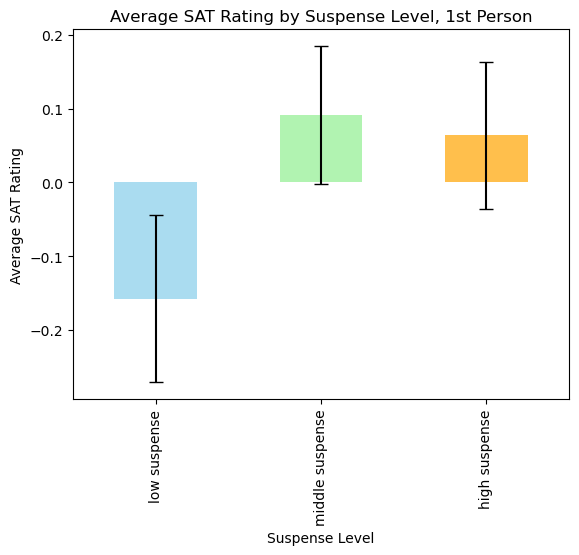

In [166]:
plot_sat_susp (sat_filtered_df)




In [167]:
def plot_sat_outcome (dataframe):

    # Group by 'suspense_level' and calculate the mean of 'sat_rating'
    grouped_df_count = dataframe.groupby('expected_outcome')['sat_rating'].count()

    grouped_df_mean = dataframe.groupby('expected_outcome')['sat_rating'].mean()

    grouped_df_sem = (dataframe.groupby('expected_outcome')['sat_rating'].std())/np.sqrt(grouped_df_count)

    # Plotting the bar plot
    ax = grouped_df_mean.plot(kind='bar', yerr=grouped_df_sem, capsize=5, color=['skyblue', 'lightgreen'], alpha=0.7)

    # Adding labels and title
    plt.xlabel('Game Outcome')
    plt.ylabel('Average SAT Rating')
    plt.title('Average SAT Rating by Game Outcome, 1st Person')

    # Show the plot
    plt.show()

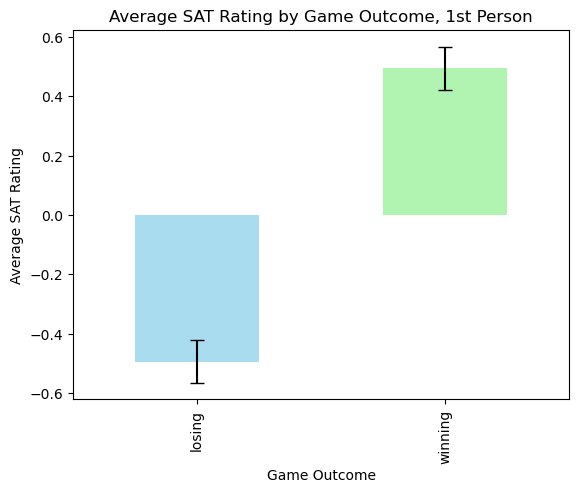

In [168]:
plot_sat_outcome (sat_filtered_df)
#plot_sat_outcome (sat_df_first_half)
#plot_sat_outcome (sat_df_second_half)

In [169]:
def plot_sat_susp_outcome(dataframe):
    # Calculate the sample size for each group
    grouped_df_count = dataframe.groupby(['suspense_level', 'expected_outcome'])['sat_rating'].count()

    # Group by both 'suspense_level' and 'expected_outcome' and calculate the mean and standard error of 'sat_rating'
    grouped_df_mean = dataframe.groupby(['suspense_level', 'expected_outcome'])['sat_rating'].mean()
    grouped_df_std = (dataframe.groupby(['suspense_level', 'expected_outcome'])['sat_rating'].std()) / np.sqrt(grouped_df_count)

    # Convert the result to a DataFrame for plotting
    grouped_df_mean = grouped_df_mean.unstack()
    grouped_df_sem = grouped_df_std.unstack()

    # Make sure order is low, mid, high
    grouped_df_mean = grouped_df_mean.reindex(['low suspense', 'middle suspense', 'high suspense'])
    grouped_df_sem = grouped_df_sem.reindex(['low suspense', 'middle suspense', 'high suspense'])

    print(grouped_df_mean)
    print(grouped_df_sem)

    # Plotting the bar plot with error bars as standard error (SEM)
    ax = grouped_df_mean.plot(kind='bar', yerr=grouped_df_sem, capsize=5, color=['skyblue', 'lightgreen'], alpha=0.7)

    # Adding labels and title
    plt.xlabel('Suspense Level', fontsize=13)
    plt.ylabel('Average SAT Rating (Z-scored)', fontsize=13)
    plt.ylim(-1.5, 1.5)

    # Perform one-sample t-tests for each group
    t_test_results = []
    for suspense_level in grouped_df_mean.index:
        for outcome in grouped_df_mean.columns:
            group_ratings = dataframe[(dataframe['suspense_level'] == suspense_level) & (dataframe['expected_outcome'] == outcome)]['sat_rating']
            t_stat, p_val = ttest_1samp(group_ratings, 0)
            t_test_results.append((f'{suspense_level} ({outcome} vs 0)', t_stat, p_val))
    
    # Display t-test results
    t_test_text = '\n'.join([f'{comparison}: t={t_stat:.2f}, adj-p={p_val:.2e}' for comparison, t_stat, p_val in t_test_results])
    print(t_test_text)

    # Perform ANOVA
    model = ols('sat_rating ~ C(suspense_level) * C(expected_outcome)', data=dataframe).fit()
    anova_results = anova_lm(model, typ=2)
    print("ANOVA results:\n", anova_results)


    # Show the plot
    plt.legend(title='Expected Outcome', loc='upper right', fontsize=13, title_fontsize='13')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.show()

expected_outcome    losing   winning
suspense_level                      
low suspense     -0.835797  0.520975
middle suspense  -0.434440  0.528562
high suspense    -0.211095  0.407604
expected_outcome    losing   winning
suspense_level                      
low suspense      0.118199  0.130725
middle suspense   0.099672  0.121622
high suspense     0.133118  0.129697
low suspense (losing vs 0): t=-7.07, adj-p=8.99e-09
low suspense (winning vs 0): t=3.99, adj-p=2.50e-04
middle suspense (losing vs 0): t=-4.36, adj-p=7.75e-05
middle suspense (winning vs 0): t=4.35, adj-p=6.31e-05
high suspense (losing vs 0): t=-1.59, adj-p=1.20e-01
high suspense (winning vs 0): t=3.14, adj-p=3.40e-03
ANOVA results:
                                            sum_sq     df          F  \
C(suspense_level)                        3.582791    2.0   2.630518   
C(expected_outcome)                     66.035750    1.0  96.968099   
C(suspense_level):C(expected_outcome)    5.801525    2.0   4.259532   
Residual  

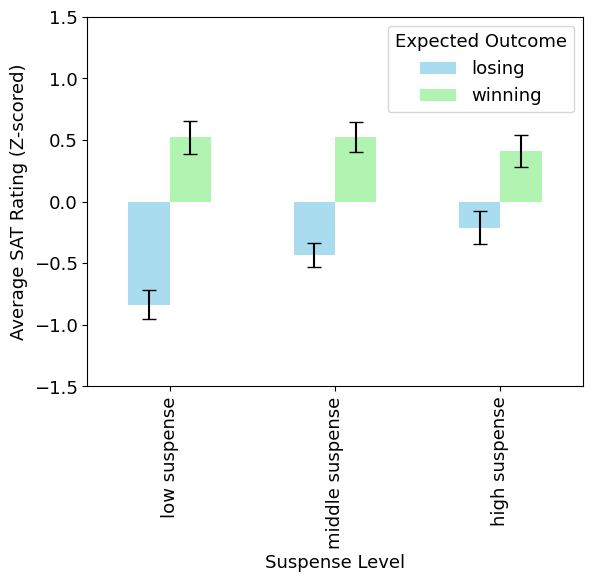

In [170]:
plot_sat_susp_outcome (sat_filtered_df)
#plot_sat_susp_outcome (sat_df_first_half)
#plot_sat_susp_outcome (sat_df_second_half)

In [171]:
#Save sat_filtered_df

sat_filtered_df

# Save the DataFrame to Excel
sat_filtered_df.to_excel('sat_filtered_df_1st_Bastien.xlsx', index=False)

In [172]:
# Merge DataFrames based on 'Game_index'
merged_df = pd.merge(sat_filtered_df, suspense_sum, on='game', how='left')

# Fill the 'suspense' column with 'Suspense_sum' values
merged_df['suspense'] = merged_df['suspense_sum'].fillna(0)

# Drop the 'Suspense_sum' column if no longer needed
merged_df = merged_df.drop(columns='suspense_sum')



Text(0.5, 1.0, 'Suspense Vs Satisfaction')

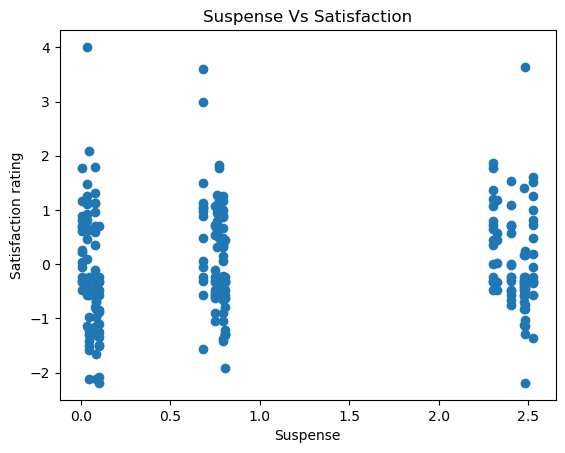

In [173]:
x = merged_df['suspense']
y = merged_df['sat_rating']

plt.scatter(x,y)

plt.xlabel('Suspense')
plt.ylabel('Satisfaction rating')
plt.title('Suspense Vs Satisfaction')

#### Linear Models

In [174]:
# Get unique participant IDs
participants_sat_df = sat_filtered_df['participant'].unique()
participants_susp_df = susp_filtered_df_1st['participant'].unique()


# Create a dictionary to store DataFrames for each participant
participant_dfs_sat = {}
participant_dfs_susp = {}

# Iterate over each participant
for participant_sat, participant_susp in zip(participants_sat_df, participants_susp_df):
    # Filter data for the current participant
    participant_df_sat = sat_filtered_df[sat_filtered_df['participant'] == participant_sat].copy()
    
    # Store the DataFrame for the current participant in the dictionary
    participant_dfs_sat[participant_sat] = participant_df_sat


    #extract suspense ratings and store them
    participant_df_susp = susp_filtered_df_1st[susp_filtered_df_1st['participant'] == participant_susp].copy()
    participant_dfs_susp[participant_susp] = participant_df_susp





In [175]:
#Compute linear model comparing satisfaction ratings and suspense sum

# Create a dictionary to store DataFrames for each participant
participant_models = {}
participant_param = {}

avg_susp_per_game = susp_filtered_df_1st.groupby(['game'])['susp_rating'].mean().reset_index(drop=True)


#first compute 17 different models (1 per participant)
for participant_susp, participant_sat in zip(participant_dfs_susp, participant_dfs_sat):
    #extract suspense rating per participant for each round per game

    #extract satisfaction per game
    sat = participant_dfs_sat[participant_sat]['sat_rating'].reset_index(drop=True)


    #Extract outcome per game
    outcome = participant_dfs_sat[participant_sat]['expected_outcome'].reset_index(drop=True)
    

    # Combine the Series into a single DataFrame
    model_df_1st = pd.DataFrame({
        'satisfaction': sat,
        'suspense': avg_susp_per_game,
        'outcome': outcome
    })


    # Encode the categorical outcome variable
    model_df_1st['outcome_encoded'] = model_df_1st['outcome'].map({'losing': 0, 'winning': 1})


    # Create the interaction term
    model_df_1st['suspense_outcome_interaction'] = model_df_1st['suspense'] * model_df_1st['outcome_encoded']


    # Define the dependent variable
    y = model_df_1st['satisfaction']

    # Define the independent variables
    X = model_df_1st[['suspense', 'outcome_encoded', 'suspense_outcome_interaction']]

    # Add a constant to the independent variables (for the intercept)
    X = sm.add_constant(X)

    # Create and fit the OLS model
    model_sat_1st_part = sm.OLS(y, X).fit()

    # Save model results to a file to compare with other model
    model_sat_1st = {
        "params": model_sat_1st_part.params.tolist(),
        "llf": model_sat_1st_part.llf,
        "aic": model_sat_1st_part.aic,
        "bic": model_sat_1st_part.bic,
        "std_err": model_sat_1st_part.bse.tolist()
    }


    participant_models[participant_sat] = model_sat_1st_part
    participant_param[participant_sat] = model_sat_1st



In [176]:
#Now check if there are statistical differences between a distribution of slopes centred around 0 and the distribution of slopes in our data
all_slopes_susp = []
all_slopes_outcome = []
all_slopes_int = []
all_const = []
for participant in participant_param:
    const = participant_param[participant]['params'][0]
    slope_susp = participant_param[participant]['params'][1]
    slope_outcome = participant_param[participant]['params'][2]
    slope_susp_and_outcome = participant_param[participant]['params'][3]
    
    all_slopes_susp.append(slope_susp)
    all_slopes_outcome.append(slope_outcome)
    all_slopes_int.append(slope_susp_and_outcome)

    all_const.append(const)



null_distribution = np.random.randn(10000000)


#save slopes from 3rd person to compare with model of 1st person

with open('all_slopes_susp_1st.json', 'w') as f:
    json.dump(all_slopes_susp, f)

with open('all_slopes_outcome_1st.json', 'w') as f:
    json.dump(all_slopes_outcome, f)

with open('all_slopes_int_1st.json', 'w') as f:
    json.dump(all_slopes_int, f)


In [177]:
#divide suspense games results by winning or losing outcomes:

participant_dfs_susp_win = {}
participant_dfs_susp_lose = {}

participant_dfs_sat_win = {}
participant_dfs_sat_lose = {}

# Iterate over each participant in participant_dfs_susp
for participant_susp, participant_sat in zip(participant_dfs_susp, participant_dfs_sat):
    # Filter the DataFrame for the current participant where expected outcome is 'winning'
    participant_dfs_susp_win[participant_susp] = participant_dfs_susp[participant_susp][participant_dfs_susp[participant_susp]['expected_outcome'] == 'winning']
    participant_dfs_susp_lose[participant_susp] = participant_dfs_susp[participant_susp][participant_dfs_susp[participant_susp]['expected_outcome'] == 'losing']

    participant_dfs_sat_win[participant_sat] = participant_dfs_sat[participant_sat][participant_dfs_sat[participant_sat]['expected_outcome'] == 'winning']
    participant_dfs_sat_lose[participant_sat] = participant_dfs_sat[participant_sat][participant_dfs_sat[participant_sat]['expected_outcome'] == 'losing']






In [178]:
#Compute linear model comparing satisfaction ratings and suspense sum for different outcomes

# Create a dictionary to store DataFrames for each participant
participant_models_win = {}
participant_param_win = {}

participant_models_lose = {}
participant_param_lose = {}


avg_susp_per_game_win = susp_filtered_df_1st[susp_filtered_df_1st['expected_outcome']=='winning'].groupby(['game'])['susp_rating'].mean().reset_index(drop=True)
avg_susp_per_game_lose = susp_filtered_df_1st[susp_filtered_df_1st['expected_outcome']=='losing'].groupby(['game'])['susp_rating'].mean().reset_index(drop=True)

#first compute 17 different models (1 per participant)
for participant_susp, participant_sat in zip(participant_dfs_susp, participant_dfs_sat):
    #extract suspense rating per participant for each round per game

    #extract satisfaction per game
    sat_win = participant_dfs_sat_win[participant_sat]['sat_rating'].reset_index(drop=True)
    sat_lose = participant_dfs_sat_lose[participant_sat]['sat_rating'].reset_index(drop=True)


    # Combine the Series into a single DataFrame
    model_df_1st_win = pd.DataFrame({
        'satisfaction': sat_win,
        'suspense': avg_susp_per_game_win,
    })


      # Combine the Series into a single DataFrame
    model_df_1st_lose = pd.DataFrame({
        'satisfaction': sat_lose,
        'suspense': avg_susp_per_game_lose,
    })


    # Define the dependent variable
    y_win = model_df_1st_win['satisfaction']
    y_lose = model_df_1st_win['satisfaction']

    # Define the independent variables
    X_win = model_df_1st_win[['suspense']]
    X_lose = model_df_1st_lose[['suspense']]

    # Add a constant to the independent variables (for the intercept)
    X_win= sm.add_constant(X_win)

    # Add a constant to the independent variables (for the intercept)
    X_lose = sm.add_constant(X_lose)

    # Create and fit the OLS model
    model_sat_1st_part_win = sm.OLS(y_win, X_win).fit()
    model_sat_1st_part_lose = sm.OLS(y_lose, X_lose).fit()

    # Save model results to a file to compare with other model
    model_sat_1st_win = {
        "params": model_sat_1st_part_win.params.tolist(),
        "llf": model_sat_1st_part_win.llf,
        "aic": model_sat_1st_part_win.aic,
        "bic": model_sat_1st_part_win.bic,
        "std_err": model_sat_1st_part_win.bse.tolist()
    }


    # Save model results to a file to compare with other model
    model_sat_1st_lose = {
        "params": model_sat_1st_part_lose.params.tolist(),
        "llf": model_sat_1st_part_lose.llf,
        "aic": model_sat_1st_part_lose.aic,
        "bic": model_sat_1st_part_lose.bic,
        "std_err": model_sat_1st_part_lose.bse.tolist()
    }


    participant_models_win[participant_sat] = model_sat_1st_part_win
    participant_param_win[participant_sat] = model_sat_1st_win
    participant_models_lose[participant_sat] = model_sat_1st_part_lose
    participant_param_lose[participant_sat] = model_sat_1st_lose



In [185]:
all_r_squared_lose

[0.15971552942629796,
 0.15846175991641354,
 0.00919895813318894,
 0.19711778693979298,
 0.14903467323682706,
 0.14903467323682695,
 0.09398311628065725,
 0.12991634102735894,
 0.21847663311959042,
 0.019520273528023546,
 0.7861649810377891,
 0.14875302678483993,
 0.037975865770173756,
 0.10276153979011993,
 0.07341103313325181]

In [179]:
all_r_squared_win=[]
all_r_squared_lose=[]

for participant_win, participant_lose in zip(participant_models_win, participant_models_lose):
    r_squared_win = participant_models_win[participant_win].rsquared
    all_r_squared_win.append(r_squared_win)

    r_squared_lose = participant_models_lose[participant_lose].rsquared
    all_r_squared_lose.append(r_squared_lose)

mean_r_squared_win = np.mean(all_r_squared_win)
mean_r_squared_lose = np.mean(all_r_squared_lose)

print(mean_r_squared_win)
print(mean_r_squared_lose)

0.1658626341947783
0.1622350794240768


In [180]:
#Now check if there are statistical differences between a distribution of slopes centred around 0 and the distribution of slopes in our data
all_slopes_susp_win = []
all_slopes_susp_lose = []
all_const_win = []
all_const_lose = []

for participant_win, participant_lose in zip(participant_param_win, participant_param_lose):
    const_win = participant_param_win[participant_win]['params'][0]
    const_lose = participant_param_lose[participant_lose]['params'][0]

    slope_susp_win = participant_param_win[participant_win]['params'][1]
    slope_susp_lose = participant_param_lose[participant_lose]['params'][1]

    all_slopes_susp_win.append(slope_susp_win)
    all_slopes_susp_lose.append(slope_susp_lose)

    
    all_const_win.append(const_win)
    all_const_lose.append(const_lose)



null_distribution = np.random.randn(10000000)


#save slopes from 3rd person to compare with model of 1st person

with open('all_slopes_susp_1st_win.json', 'w') as f:
    json.dump(all_slopes_susp_win, f)

with open('all_slopes_susp_1st_lose.json', 'w') as f:
    json.dump(all_slopes_susp_lose, f)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

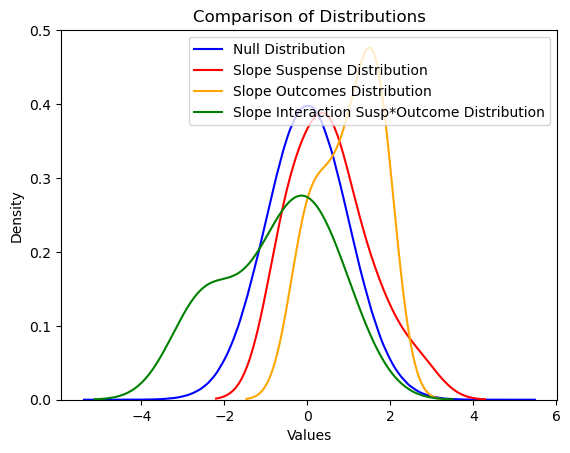

In [181]:
# Plot the KDE curve for null distribution
sns.kdeplot(null_distribution, color='blue', label='Null Distribution')

# Plot the KDE curve for distribution of slopes
sns.kdeplot(all_slopes_susp, color='red', label='Slope Suspense Distribution')

# Plot the KDE curve for distribution of slopes
sns.kdeplot(all_slopes_outcome, color='orange', label='Slope Outcomes Distribution')

sns.kdeplot(all_slopes_int, color='green', label='Slope Interaction Susp*Outcome Distribution')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Comparison of Distributions')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [182]:
from scipy import stats

In [183]:
# List of slope sets to compare
slope_sets = {
    'Suspense Slopes': all_slopes_susp,
    'Outcome Slopes': all_slopes_outcome,
    'Interaction Slopes': all_slopes_int
}

# Perform t-test for each set of slopes
alpha = 0.05
t_test_results = {}

for name, slopes in slope_sets.items():
    t_statistic, p_value = stats.ttest_1samp(slopes, 0)
    t_test_results[name] = (t_statistic, p_value)
    print(f"T-test for {name}:")
    print(f"T-statistic: {t_statistic}, P-value: {p_value}")
    if p_value < alpha:
        print("The two distributions are significantly different.\n")
    else:
        print("The two distributions are not significantly different.\n")

# Plotting the distributions for visual comparison
plt.figure(figsize=(14, 7))

T-test for Suspense Slopes:
T-statistic: 2.2813934768233795, P-value: 0.038690143723679155
The two distributions are significantly different.

T-test for Outcome Slopes:
T-statistic: 5.3814544099759924, P-value: 9.679505885496104e-05
The two distributions are significantly different.

T-test for Interaction Slopes:
T-statistic: -2.2217281565818188, P-value: 0.043298039463101796
The two distributions are significantly different.



<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>